# A Simple Framework for Contrastive Learning of Visual Representations
* [paper](https://arxiv.org/abs/2002.05709)
* [weights](https://console.cloud.google.com/storage/browser/simclr-checkpoints/simclrv1?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false)


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import random_split, Subset
from torch.optim import Adam

from torchvision import transforms as T
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, resnet50

import tensorflow as tf
import tensorflow_hub as hub

from PIL import Image

import matplotlib.pyplot as plt

/home/bradley/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-09 16:09:08.785741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [112]:
import utils.helpers as helpers

imagenet1k_labels = helpers.get_labels('labels/imagenet1k_labels.txt')
cifar10_labels = helpers.get_labels('labels/cifar10_labels.txt')

## Getting and Converting Weights

In [215]:
# tensorflow weights in hub format to pytorch 
def from_tensorflow_hub(path, torch_layers):
    state_dict = {}
    tf_layers = hub.load(path).variables
    for layer in tf_layers:
        name = layer.name
        weights = torch.from_numpy(layer.numpy())
        name = name[:-2]
        name = 'encoder.' + name
        name = name.replace('/', '.')
        name = name.replace('kernel', 'weight')
        name = name.replace('moving', 'running')
        name = name.replace('gamma', 'weight')
        name = name.replace('beta', 'bias')
        name = name.replace('variance', 'var')
        name = name.replace('batch_normalization', 'bn')
        name = name.replace('conv2d', 'conv')
        name = name.replace('dense', 'fc.ff1')
        h1, _, t1 = name.partition('_')
        if t1 != '' and t1[0].isdigit():
            h2, _, t2 = h1.partition('.')
            num, _, t3 = t1.partition('.')
            num = int(num)
            layer_idx = 'layer'

            # get layer_idx and normalize num
            if num <= 10:   # name 1 (10 = 3blocks * 3convs + 1)
                layer_idx += '1'
            elif num <= 23: # name 2 (23 = prev + 4blocks * 3convs + 1)
                num -= 10
                layer_idx += '2'
            elif num <= 42: # name 3 (42 = prev + 6blocks * 3convs + 1)
                num -= 23
                layer_idx += '3'
            else:           # name 4 (52 = prev + 3blocks * 3convs + 1)
                num -= 42
                layer_idx += '4'

            # change name name
            if num == 1 and 'conv' in name:
                name = '.'.join([h2, layer_idx, '0', 'downsample.0', t3])
            elif num == 1 and 'bn' in name:
                name = '.'.join([h2, layer_idx, '0', 'downsample.1', t3])
            else:
                num -= 2
                block, idx  = divmod(num, 3)
                name = '.'.join([h2, layer_idx, str(block),
                                  ('conv' if 'conv' in name else 'bn') + str(idx+1), t3])
        elif 'conv.' in name:
            name = name.replace('conv.', 'conv1.')
        elif 'bn.' in name:
            name = name.replace('bn.', 'bn1.')

        assert name in torch_layers
        state_dict[name] = weights

    # this won't work inside other loop, gives error about EagerTensor. Why?
    # TODO: look into why it won't work
    for layer in state_dict:
        # permuting weights
        if 'conv' in layer or 'downsample.0' in layer:
            state_dict[layer] = state_dict[layer].permute(3,2,0,1)
        elif 'ff' in layer and 'weight' in layer:
            state_dict[layer] = state_dict[layer].T

        assert state_dict[layer].shape == torch_layers[layer].shape,\
             f"{layer}, {state_dict[layer].shape} != {torch_layers[layer].shape}"

    return state_dict

In [113]:
# convert simclr tf_weights to pytorch_weights
def to_pytorch(tf_weights, model_dict):
    torch_weights = dict()
    for layer in tf_weights:
        weights = torch.from_numpy(tf_weights[layer])
        layer = layer.replace('/', '.')
        layer = layer.replace('base_model', 'encoder')
        layer = layer.replace('kernel', 'weight')
        layer = layer.replace('moving', 'running')
        layer = layer.replace('gamma', 'weight')
        layer = layer.replace('beta', 'bias')
        layer = layer.replace('variance', 'var')
        layer = layer.replace('batch_normalization', 'bn')
        layer = layer.replace('conv2d', 'conv')
        layer = layer.replace('head_supervised.linear_layer.dense', 'encoder.fc.ff1')
        h1, _, t1 = layer.partition('_')
        if t1 != '' and t1[0].isdigit():
            h2, _, t2 = h1.partition('.')
            num, _, t3 = t1.partition('.')
            num = int(num)
            layer_idx = 'layer'

            # get layer_idx and normalize num
            if num <= 10:   # layer 1 (10 = 3blocks * 3convs + 1)
                layer_idx += '1'
            elif num <= 23: # layer 2 (23 = prev + 4blocks * 3convs + 1)
                num -= 10
                layer_idx += '2'
            elif num <= 42: # layer 3 (42 = prev + 6blocks * 3convs + 1)
                num -= 23
                layer_idx += '3'
            else:           # layer 4 (52 = prev + 3blocks * 3convs + 1)
                num -= 42
                layer_idx += '4'

            # change layer name
            if num == 1 and 'conv' in layer:
                layer = '.'.join([h2, layer_idx, '0', 'downsample.0', t3])
            elif num == 1 and 'bn' in layer:
                layer = '.'.join([h2, layer_idx, '0', 'downsample.1', t3])
            else:
                num -= 2
                block, idx  = divmod(num, 3)
                layer = '.'.join([h2, layer_idx, str(block),
                                  ('conv' if 'conv' in layer else 'bn') + str(idx+1), t3])
        elif 'conv.' in layer:
            layer = layer.replace('conv.', 'conv1.')
        elif 'bn.' in layer:
            layer = layer.replace('bn.', 'bn1.')

        # permuting weights
        if 'conv' in layer or 'downsample.0' in layer:
            weights = weights.permute(3,2,0,1)
        elif 'ff' in layer and 'weight' in layer:
            weights = weights.T

        if layer not in model_dict:
            print(layer)
        assert layer in model_dict, "layer not in resnet model"
        assert layer not in torch_weights, "layer already in dict"
        torch_weights[layer] = weights

    return torch_weights

In [ ]:
# WEIGHT_TYPE = 'finetune_10pct'
# WEIGHT_TYPE = 'finetune_100pct'
WEIGHT_TYPE = 'pretrain'
!rm -r ./data/1x
!gsutil -m cp -r \
  "gs://simclr-checkpoints/simclrv1/{WEIGHT_TYPE}/1x" \
  ./data

## Model

SimCLR uses ResNet-50 for the encoder model.

In [213]:
class TrainHead(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.ff1 = nn.Linear(params['h_dim'], 2048)
        self.ff2 = nn.Linear(2048, 128)

    def forward(self, x):
        out = torch.relu(self.ff1(x))
        out = self.ff2(out)
        return out

class LinearClassifierHead(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.ff1 = nn.Linear(params['h_dim'], params['num_classes'])

    def forward(self, x):
        out = self.ff1(x)
        return out

class SimCLR(nn.Module):
    def __init__(self, base: nn.Module=resnet50, head: nn.Module=None, num_classes: int=1000, cifar: bool=False):
        super().__init__()
        self.encoder = base()
        head_params = {
            'h_dim': self.encoder.fc.in_features, 
            'num_classes': num_classes, 
            'cifar': cifar
        }
        if head:
            self.encoder.fc = head(head_params)
        else:
            self.encoder.fc = nn.Identity()

        # paper says for cifar10 they swapped conv7x7 with conv3x3
        # but the pretrained weights use conv7x7, and also only works
        # when cifar10 resized to 224x224.
        # 
        # even in source code they use conv3x3, but their weights use
        # conv7x7
        if cifar:
            self.encoder.conv1 = nn.Conv2d(3, 64, 3, bias=False)
            self.maxpool = nn.Identity()
    
    def forward(self, x):
        out = self.encoder(x)
        return out

    # TODO: better load_weights function names/combination
    def load_weights(self, path):
        state_dict = from_tensorflow_hub(path, self.state_dict())
        self.load_state_dict(state_dict)

    def load_pretrained_weights(self):
        params = self.state_dict()
        vars = map(lambda x: x[0], tf.train.list_variables('data/1x'))
        
        reader = tf.train.load_checkpoint('data/1x')
        layers = {layer: reader.get_tensor(layer)\
                for layer in vars if layer != 'global_step'\
                    and 'Momentum' not in layer}
        
        print(len(layers))
        loaded_params = to_pytorch(layers, params)
        for layer in params:
            if layer not in loaded_params:
                loaded_params[layer] = torch.zeros_like(params[layer])
        
        self.load_state_dict(loaded_params)


Results for this part are not that interesting (architecture is just resnet). Just needed to verify model architecture is right/working. The training results and fine tuning are the most interesting part.

In [214]:
ts = T.Compose([T.ToTensor(), T.Resize((224,224))])
img = Image.open('imgs/bear.jpg')

model = SimCLR(resnet50, LinearClassifierHead, len(imagenet1k_labels.keys()), cifar=False)
model.load_pretrained_weights()
model.eval()

inp = ts(img).unsqueeze(0)
print(f'Class: {imagenet1k_labels[torch.argmax(model(inp)).item()]}')

267
Class: brown bear, bruin, Ursus arctos


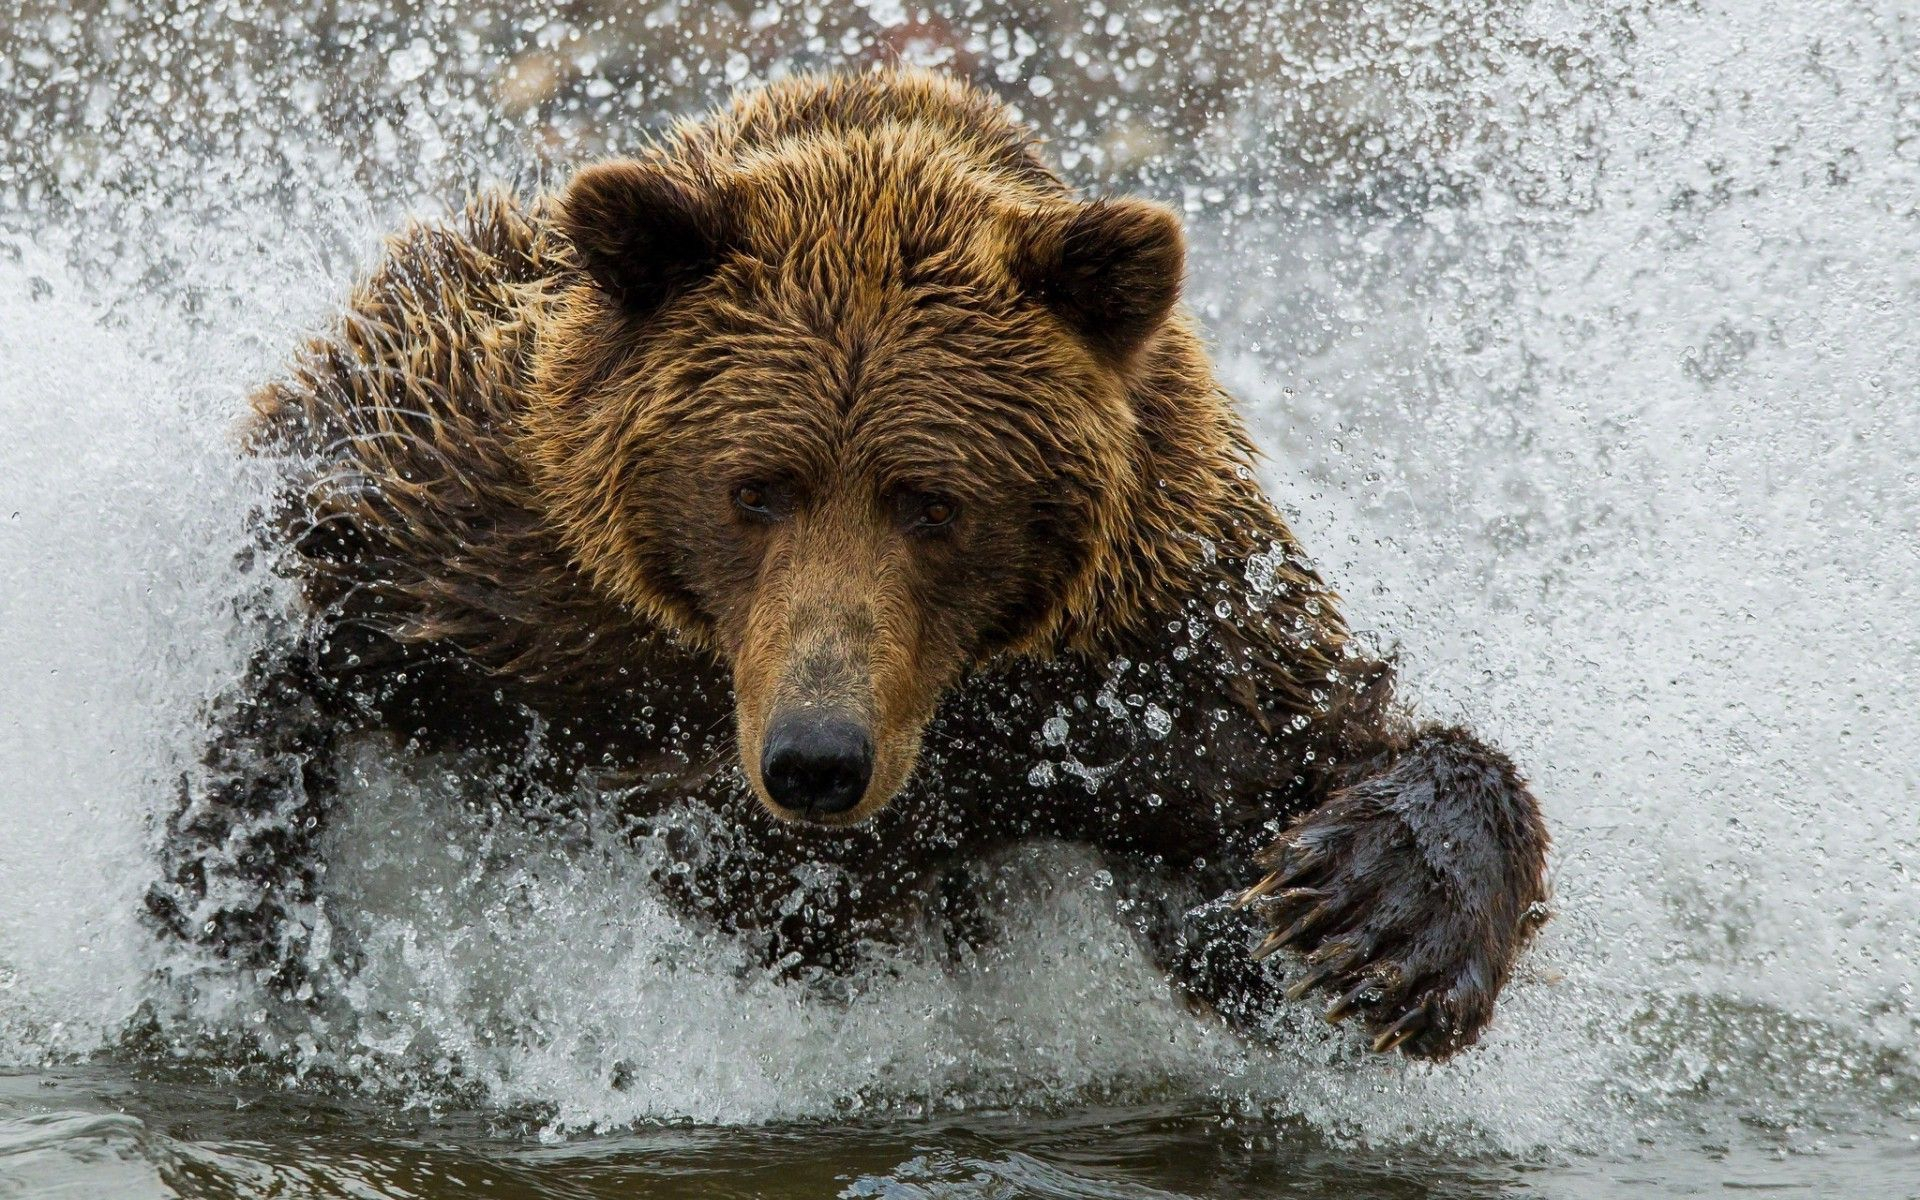

In [6]:
img

## Training

Train using CIFAR10 because I don't have time to train on Imagenet right now

### Pretraining

In [118]:
class ContrastiveAugs:
    def __init__(self, ts):
        self.ts = ts

    def __call__(self, x):
        x1 = self.ts(x)
        x2 = self.ts(x)
        return x1, x2

augs = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomResizedCrop(size=32),
        T.RandomApply([T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
        T.RandomGrayscale(p=0.2),
        T.GaussianBlur(kernel_size=9),
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,)),
])

ds = CIFAR10(
    root='data/cifar10_train',
    train=True,
    transform=ContrastiveAugs(augs),
    download=True
)

tds = CIFAR10(
    root='data/cifar10_train',
    train=True,
    transform=T.ToTensor(),
    download=True
)


# train_ds, val_ds = random_split(ds, (0.8, 0.2))
train_ds, val_ds = random_split(ds, (int(.8*len(ds)), int(.2*len(ds))))

test_ds = CIFAR10(
    root='data/cifar10_test',
    train=False,
    transform=ContrastiveAugs,
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [133]:
import torch.nn.functional as F
def similarity(u, v):
    # Z_1..2*N
    z = torch.cat((u, v), 0)
    cos_sim = torch.cosine_similarity(z[:,None,:], z[None,:,:], -1)
    return cos_sim

# [1] https://pytorch-lightning.readthedocs.io/en/stable/notebooks/course_UvA-DL/13-contrastive-learning.html
# [2] https://github.com/Spijkervet/SimCLR/blob/master/simclr/modules/nt_xent.py
# [3] https://github.com/google-research/simclr/blob/bfe07eed7f101ab51f3360100a28690e1bfbf6ec/objective.py#L38
# apparently i had this wrong before, so i yanked this part from [2]
# now it matches, but now it no work :(
def nt_xent(sim, temp):
    criterion = nn.CrossEntropyLoss()

    N = sim.size(0) // 2
    sim /= temp
    mask = torch.eye(2*N, dtype=bool)
    mask = ~mask & ~mask.roll(N, dims=-1)
    
    sim_i_j = torch.diag(sim, N)
    sim_j_i = torch.diag(sim, -N)
    pos_samples = (torch.cat((sim_i_j, sim_j_i), dim=0)).reshape(2*N, 1)
    pos_labels = torch.ones(pos_samples.shape).to(pos_samples.device)
    neg_samples = sim[mask].reshape(2*N, -1)
    neg_labels = torch.zeros(neg_samples.shape).to(neg_samples.device)
    labels = torch.cat((pos_labels, neg_labels), dim=-1)
    logits = torch.cat((pos_samples, neg_samples), dim=1)
    loss = criterion(logits, labels)

    return loss

In [65]:
def save_checkpoint(model, optim, epoch, loss, path):
    torch.save({
        'optimizer': optim.state_dict(),
        'model': model.state_dict(),
        'epoch': epoch,
        'loss': loss,
    }, path)

In [176]:
from tqdm import tqdm

def pretrain_one_epoch(model: nn.Module, train_dl: torch.utils.data.DataLoader,\
                        optim: torch.optim.Optimizer, params: dict) -> list:
    losses = []
    model.train()
    for ((X1, X2), _) in tqdm(train_dl):
        optim.zero_grad()
        x1 = X1.to(params['device'])
        x2 = X2.to(params['device'])
        z1 = model(x1)
        z2 = model(x2)
        
        # sim = similarity(z1, z2)
        # loss = nt_xent(sim, params['temp'])
        # loss = ContrastiveLoss(x1.size(0), params['temp'])(z1, z2)
        # loss = nt_xent(torch.cat((z1, z2), dim=0), params['temp'])
        loss = tf_nt_xent(z1, z2, params['temp'])

        loss.backward()
        optim.step()

        losses.append(loss.item())
    return losses

def pretrain_validation(model: nn.Module, val_dl: torch.utils.data.DataLoader,\
                        params: dict) -> list:
    losses = []
    model.eval()
    for ((X1, X2), _) in tqdm(val_dl):
        x1 = X1.to(params['device'])
        x2 = X2.to(params['device'])
        z1 = model(x1)
        z2 = model(x2)

        # loss = nt_xent(similarity(z1, z2), params['temp'])
        # loss = ContrastiveLoss(z1.size(0), params['temp'])(z1, z2)
        # loss = nt_xent(torch.cat((z1, z2), dim=0), params['temp'])
        loss = tf_nt_xent(z1, z2, params['temp'])

        losses.append(loss.item())
    return losses

def pretrain(model, train_dl, val_dl, optim, params):
    train_losses = []
    val_losses = []
    start_epoch = 0
    if params['checkpoint']:
        chkpt = torch.load('checkpoint')
        model.load_state_dict(chkpt['model'])
        optim.load_state_dict(chkpt['optimizer'])
        start_epoch = chkpt['epoch']
    for i in tqdm(range(params['epochs'])):
        # training set
        print("training set")
        losses = pretrain_one_epoch(model, train_dl, optim, params)
        train_losses += losses

        if i % 3 == 0:
            # validation set
            print("validation set")
            losses = pretrain_validation(model, val_dl, params)
            val_losses += losses
            print(f"AVG VAL LOSS -- EPOCH {i}:", sum(losses)/len(losses),'\n')

            save_checkpoint(model, optim, i, train_losses[i], f'checkpoints/checkpoint-epoch{i+start_epoch}-pretraining.pt')

    return train_losses, val_losses


In [181]:
# use when just making sure something works
default_params = {
    'epochs': 1,
    'temp': 0.05,
    'bs': 256,
    'lr': 2e-3,
    'device': 'cuda',
    'checkpoint': None,
}

# these are not searched for optimal values, just a first choice
params = {
    'epochs': 10,
    'temp': 0.05,
    'bs': 256,
    'lr': 2e-3,
    'device': 'cuda',
    'checkpoint': None,
}

# TODO: (MAYBE) try searching for better settings, but maybe wait to try in MOCOv2
# because that version is less computationaly expensive

# params = default_params
# params['checkpoint'] = 'checkpoints/checkpoint-epoch18-pretraining.pt'
# params['criterion'] = NT_Xent(params['bs'], params['temp'])

model = SimCLR(resnet18, TrainHead, cifar=True)

model = model.cuda()
optim = Adam(model.parameters(), params['lr'])

train_dl = torch.utils.data.DataLoader(
    dataset=train_ds,
    batch_size=params['bs'],
    shuffle=True,
)

val_dl = torch.utils.data.DataLoader(
    dataset=val_ds,
    batch_size=params['bs'],
    shuffle=True,
)

In [178]:
total = 0
for i in model.parameters():
    mul = 1
    for j in i.shape:
        mul *= j
    total += mul

print(total / 1e6, 'Million parameters')

12.481728 Million parameters


In [ ]:
# ~1h per 10 epochs with rtx 2060
train_losses, val_losses = pretrain(model, train_dl, val_dl, optim, params)

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(val_losses)

### CIFAR10 1% Fine Tune

In [34]:
# TODO: figure number of images per class, and sample 1% of each class
# use normal regression training loop

### CIFAR10 10% Fine Tune

In [33]:
# TODO: figure number of images per class, and sample 10% of each class
# use normal regression training loop